In [16]:
import json
import psycopg2
import urllib.parse as up
import pandas as pd
import re
import urllib3
from datetime import date
import os
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [19]:
#Connect to Database and convert relevent data into a DataFrame
#Connect to Database
parentDir = os.path.dirname(os.getcwd())
cred = json.load(open(parentDir+'/PSQLCredentials.json'))
url = up.urlparse(cred[1]['connString'])
conn = psycopg2.connect(database=url.path[1:], user=url.username, password=url.password, host=url.hostname, port=url.port )
cursor  = conn.cursor()
cursor.execute("select * from (select caryear, mileage, model, ownercount, accidentcount, price, Case When transmission like '%Manual%' Then 'Manual' When transmission like '%Automatic%' Then 'Automatic' Else 'Unknown' End transmission from listings where caryear is not null and mileage is not null and transmission is not null and model is not null and accidentcount is not null and ownercount is not null) a where a.transmission != 'Unknown'")
conn.commit()
df = pd.DataFrame(cursor.fetchall())
cursor .close()
conn.close()
#Add column names to dataframe
df = df.rename(columns = {0:'Year', 1:'Mileage', 2: 'Maker', 3:'OwnerCount', 4:'AccidentCount', 5:'Price', 6:'Transmission'})
#Convert all numerical data into float
df[["Price"]] = df[["Price"]].apply(pd.to_numeric)
#Create dummy data for categorical data types
df['Maker'] = df['Maker'].map({'Toyota 86': 0, 'Subaru BRZ': 1})
df['Transmission'] = df['Transmission'].map({'Manual': 0, 'Automatic': 1})


Steps for creating multiple regression model(least squares):
1) Selecting variables
2) Selecting form of multiple regression equation
3) Checking for violations of underlying assumptions

1) Selecting variables:
  - checking for collinearity


([<matplotlib.axis.XTick at 0x2524a1b7d60>,
 [Text(-0.2, 0, '−0.2'), Text(0.0, 0, '0.0')])

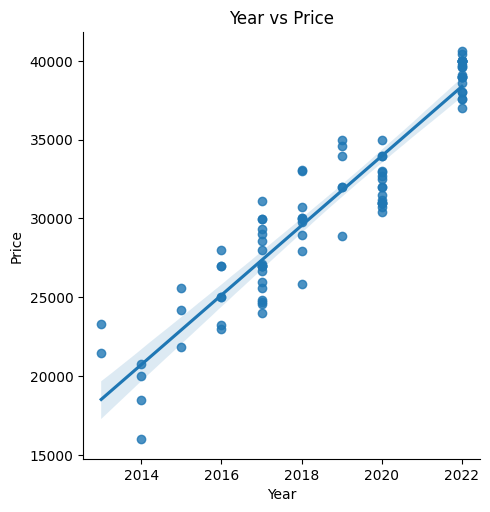

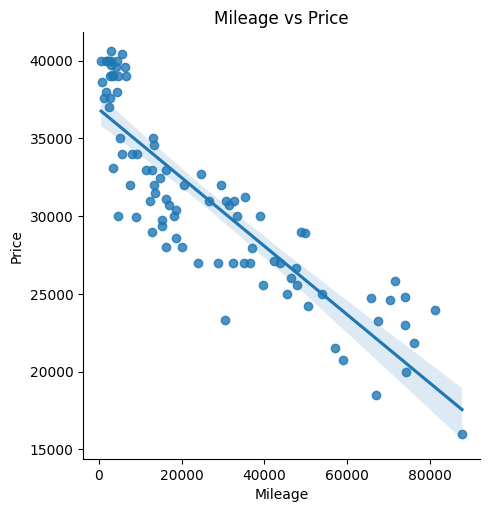

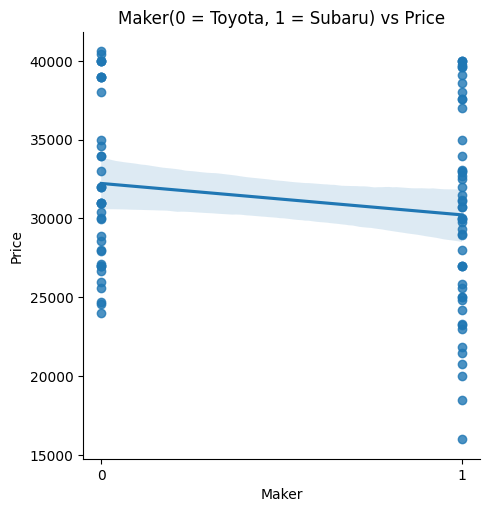

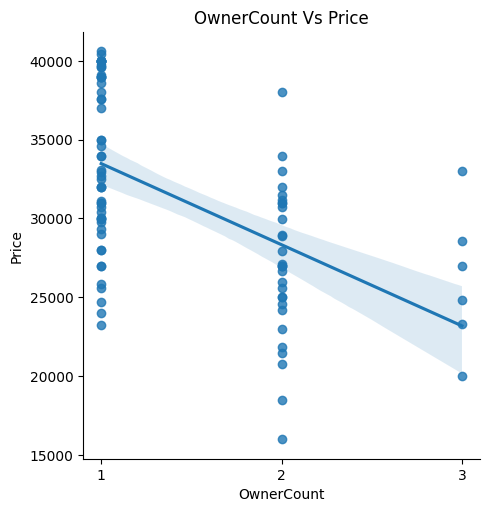

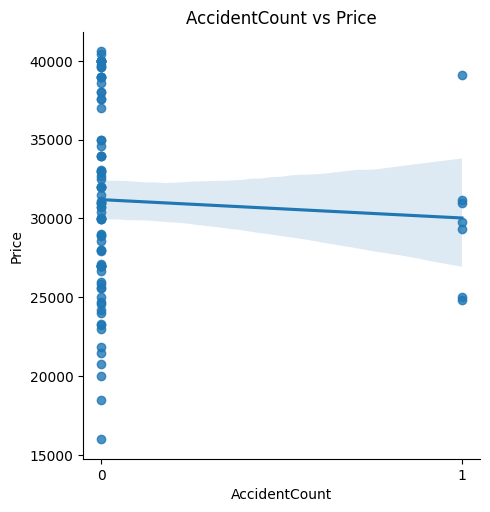

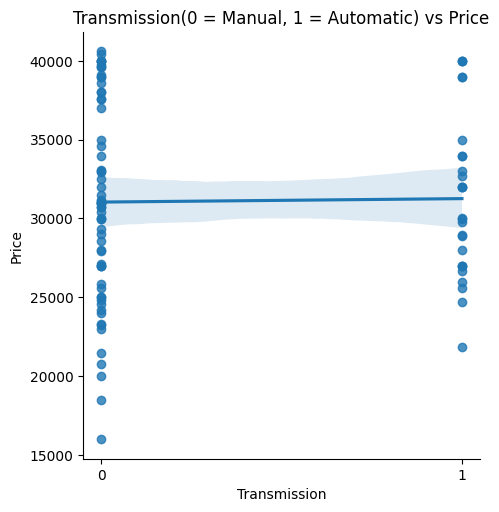

In [36]:
sns.lmplot(x="Year", y = "Price", data = df, order=1)
plt.title('Year vs Price')

sns.lmplot(x="Mileage", y = "Price", data = df, order=1)
plt.title('Mileage vs Price')

sns.lmplot(x="Maker", y = "Price", data = df, order=1)
plt.xticks(np.arange(min(df["Maker"]), max(df["Maker"])+1, 1.0))
plt.title('Maker(0 = Toyota, 1 = Subaru) vs Price')

sns.lmplot(x="OwnerCount", y = "Price", data = df, order=1)
plt.title('OwnerCount Vs Price')
plt.xticks(np.arange(min(df["OwnerCount"]), max(df["OwnerCount"])+1, 1.0))

sns.lmplot(x="AccidentCount", y = "Price", data = df, order=1)
plt.title('AccidentCount vs Price')
plt.xticks(np.arange(min(df["AccidentCount"]), max(df["AccidentCount"])+1, 1.0))

sns.lmplot(x="Transmission", y = "Price", data = df, order=1)
plt.title('Transmission(0 = Manual, 1 = Automatic) vs Price')
plt.xticks(np.arange(min(df["Transmission"]), max(df["Transmission"])+1, 1.0)) 

In [28]:

coordf = df.drop(columns=["Price"])
coordf.corr()


,Year,Mileage,Maker,OwnerCount,AccidentCount,Transmission
Year,1.000000,-0.746001,-0.217158,-0.509753,-0.015014,0.019080
Mileage,-0.746001,1.000000,0.135720,0.499406,0.077145,-0.043377
Maker,-0.217158,0.135720,1.000000,0.088364,0.172567,-0.394135
OwnerCount,-0.509753,0.499406,0.088364,1.000000,0.118299,-0.057007
AccidentCount,-0.015014,0.077145,0.172567,0.118299,1.000000,-0.097222
Transmission,0.019080,-0.043377,-0.394135,-0.057007,-0.097222,1.000000


all correlation coefficients fall between (-0.8, 8) therefore there isn't a collinearity issue with our independent variables

2) Selecting and creating best-fitting model using forwards selection Credits: https://planspace.org/20150423-forward_selection_with_statsmodels/

In [35]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

model = forward_selected(df, 'Price')
print(model.model.formula)
print(model.rsquared_adj)

Price ~ Year + Mileage + Maker + 1
0.9513243629158565


In [57]:
import statsmodels.api as sm
X = df[['Year', 'Mileage', 'Maker']]
X = sm.add_constant(X)
Y = df[["Price"]]
mod = sm.OLS(Y, X)
res = mod.fit()

model = res.params
print(model)
intercept = model[0]
yearCoef = model[1]
mileageCoef = model[2]
makerCoef = model[3]





const     -3.087983e+06
Year       1.546259e+03
Mileage   -9.707193e-02
Maker      3.480407e+02
dtype: float64
-3087983.129942199
1546.2588179767663
-0.09707193363563626
348.0406892744552
19915.494424672797


In [40]:
print(df.dtypes)

Year               int64
Mileage            int64
Maker             object
OwnerCount         int64
AccidentCount      int64
Price            float64
Transmission      object
dtype: object
